In [1]:
#Loading required libraries
import os
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

from keras import losses
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential 
from keras.optimizers import Adam
from keras import optimizers
from keras import backend as K
from keras.callbacks import Callback
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import tensorflow as tf
import pickle

from pylab import rcParams

Using TensorFlow backend.


In [2]:
#Loading train data
train=pd.read_csv("../input/train.csv")

Data Exploration

In [3]:
#Data
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
#Shape of data
train.shape

(595212, 59)

In [5]:
#Data subset
train , _ = train_test_split(train, train_size = 0.1)

In [6]:
#Shape of data
train.shape

(59521, 59)

In [7]:
#Exploring missing values
train.isnull().sum()[train.isnull().sum() !=0]

Series([], dtype: int64)

In [8]:
#Replaceming missing values witn Nan
train = train.replace(-1, np.NaN)

In [9]:
#Again missing values check
train.isnull().sum()[train.isnull().sum() !=0]

ps_ind_02_cat       17
ps_ind_04_cat        5
ps_ind_05_cat      600
ps_reg_03        10882
ps_car_01_cat        7
ps_car_03_cat    40944
ps_car_05_cat    26467
ps_car_07_cat     1127
ps_car_09_cat       46
ps_car_11            1
ps_car_14         4268
dtype: int64

,features,missing_count,missing_count_percentage
0,ps_ind_02_cat,17,0.002856
1,ps_ind_04_cat,5,0.000840
2,ps_ind_05_cat,600,0.100804
3,ps_reg_03,10882,1.828256
4,ps_car_01_cat,7,0.001176
5,ps_car_03_cat,40944,6.878894
6,ps_car_05_cat,26467,4.446651
7,ps_car_07_cat,1127,0.189344
8,ps_car_09_cat,46,0.007728
9,ps_car_11,1,0.000168


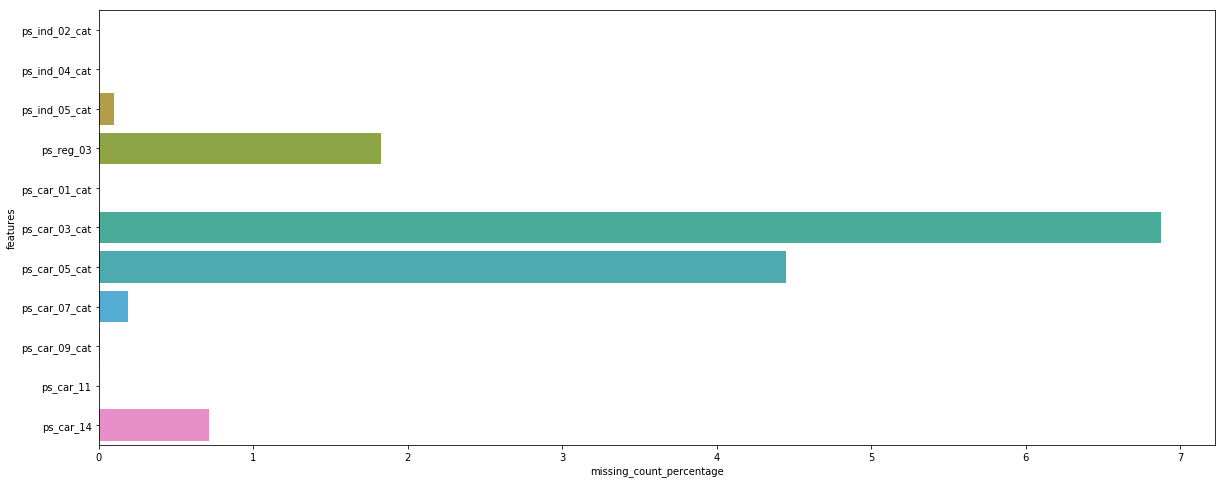

In [10]:
#Missing values in percentage
train_missing= train.isnull().sum()[train.isnull().sum() !=0]
train_missing=pd.DataFrame(train_missing.reset_index())
train_missing.rename(columns={'index':'features',0:'missing_count'},inplace=True)
train_missing['missing_count_percentage']=((train_missing['missing_count'])/595212)*100
plt.figure(figsize=(20,8))
sns.barplot(y=train_missing['features'],x=train_missing['missing_count_percentage'])
train_missing

In [11]:
#Outlier detection
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952100e+04,59521.000000,59521.000000,59504.000000,59521.000000,59516.000000,58921.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,48639.000000,59514.000000,59521.000000,18577.000000,59521.000000,33054.000000,59521.000000,58394.000000,59521.000000,59475.000000,59521.000000,59521.000000,59520.000000,59521.000000,59521.000000,55253.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000
mean,7.454628e+05,0.036239,1.905227,1.364312,4.428000,0.415670,0.426995,0.392467,0.254414,0.165202,0.187917,0.000370,0.001630,0.009560,0.000924,0.012483,7.306917,0.662707,0.122663,0.150922,0.610418,0.439976,0.894180,8.299257,0.833269,0.606449,0.727794,0.526563,6.505418,0.948145,0.830295,1.329063,0.992389,62.049193,2.344607,0.380047,0.812703,0.374572,3.067908,0.448378,0.451792,0.450083,2.372306,1.894323,7.689521,3.005662,9.225853,2.335361,8.411905,5.440786,1.447960,2.877808,7.544329,0.121974,0.628064,0.553788,0.289847,0.352665,0.155777
std,4.293460e+05,0.186887,1.988299,0.667129,2.697662,0.492841,1.361146,0.488304,0.435535,0.371366,0.390649,0.019222,0.040337,0.097306,0.030384,0.126717,3.540153,0.472790,0.328052,0.357975,0.287668,0.405155,0.345260,2.500181,0.372739,0.488550,2.152080,0.499301,5.495829,0.221735,0.375376,0.974150,0.091062,33.094695,0.837277,0.057951,0.222342,0.045766,0.729719,0.288438,0.287425,0.287368,1.118197,1.138533,1.333315,1.417590,1.453542,1.246816,2.881609,2.320967,1.210665,1.699938,2.739316,0.327258,0.483325,0.497103,0.453695,0.477804,0.362647
min,1.600000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.141421,0.291193,0.118322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.716530e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.633936,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.671498,0.349857,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.492730e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.801171,7.000000,1.000000,1.000000,0.000000,1.000000,6.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.766256,

Data PreProcessing

1.Missing value Treatment

In [12]:
#Mode imputation for Categoricval variables
Categorical  = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 
                   'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11']

train[Categorical] = train[Categorical].apply(lambda x:x.fillna(x.value_counts().index[0]))

In [13]:
#Missing values
train_missing= train.isnull().sum()[train.isnull().sum() !=0]
train_missing=pd.DataFrame(train_missing.reset_index())
train_missing.rename(columns={'index':'features',0:'missing_count'},inplace=True)
train_missing['missing_count_percentage']=((train_missing['missing_count'])/59381)*100
train_missing

,features,missing_count,missing_count_percentage
0,ps_reg_03,10882,18.325727
1,ps_car_14,4268,7.187484


In [14]:
#Mean imputation for Categoricval variables
Continuos =['ps_reg_03', 'ps_car_12', 'ps_car_14']
for col in Continuos:
    train[col].fillna(train[col].mean(), inplace=True)

In [15]:
#Missing values
train_missing= train.isnull().sum()[train.isnull().sum() !=0]
train_missing=pd.DataFrame(train_missing.reset_index())
train_missing.rename(columns={'index':'features',0:'missing_count'},inplace=True)
train_missing['missing_count_percentage']=((train_missing['missing_count'])/59381)*100
train_missing

,features,missing_count,missing_count_percentage


2.Categorical varaible transformation

In [16]:
categorical = [c for c in train.columns if "_cat" in c]
categorical

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [17]:
#one hot encoding
train = pd.get_dummies(train, columns=[i for i in categorical])

Modelling

1)Dataset split

In [18]:
#Shape of train data
train.shape

(59521, 220)

In [19]:
#Dataset split
train_data, test_data = train_test_split(train, test_size = 0.15)
print(train_data.shape)
print(test_data.shape)

(50592, 220)
(8929, 220)


In [20]:
#traindata
test_data.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,...,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
350930,876704,0,0,8,0,1,0,0,0,0,0,0,0,8,1,0,0,0.8,0.3,1.083109,3.0,0.316228,0.680529,0.361525,3.000000,0.2,0.7,0.4,3,1,9,2,7,3,16,2,1,7,5,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
565954,1414982,0,3,3,0,1,0,0,0,0,0,0,0,4,1,0,0,0.4,0.0,1.658501,0.0,0.399750,0.768988,0.423084,3.464102,0.3,0.0,0.1,3,0,5,1,9,4,10,4,0,2,5,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
463085,1157468,0,0,7,0,1,0,0,0,0,0,0,0,12,0,0,1,0.8,0.1,0.479583,1.0,0.316228,0.630050,0.347275,3.162278,0.5,0.4,0.8,3,2,8,4,10,1,8,5,3,4,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
187143,467820,0,2,3,0,1,0,0,0,0,0,0,0,2,0,0,1,0.7,0.3,0.779824,3.0,0.316228,0.649412,0.301662,3.162278,0.0,0.5,0.6,2,3,9,5,8,3,8,7,2,5,7,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
368324,920387,0,0,8,1,0,0,0,0,0,0,0,0,10,1,0,0,0.7,0.5,0.880341,2.0,0.447214,1.264976,0.417493,3.741657,0.1,0.7,0.3,1,2,8,3,8,3,8,7,2,6,4,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
#traindata
train_data.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,...,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
141185,352596,0,5,2,0,1,0,0,0,0,0,0,0,2,1,0,0,0.7,0.4,0.621490,1.0,0.316070,0.593491,0.374433,2.236068,0.4,0.0,0.2,3,0,6,2,8,4,12,2,3,2,3,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
407453,1018452,0,0,5,0,1,0,0,0,0,0,0,0,3,0,0,1,0.0,0.0,0.894180,3.0,0.316228,0.849927,0.310322,3.741657,0.2,0.4,0.6,2,3,6,3,9,2,11,6,2,3,13,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
113403,283780,0,5,9,0,0,0,1,0,0,0,0,0,7,1,0,0,0.7,0.4,0.743303,1.0,0.315595,0.388204,0.374572,0.000000,0.4,0.6,0.9,1,4,8,4,10,3,8,5,0,2,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
300038,749707,0,1,7,1,0,0,0,0,0,0,0,0,4,1,0,0,0.9,0.2,0.552834,3.0,0.316228,0.605740,0.361939,2.828427,0.9,0.2,0.3,4,1,10,2,11,2,12,4,1,5,6,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
281769,704077,0,1,2,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.7,0.937750,3.0,0.374166,0.702240,0.390768,3.162278,0.5,0.1,0.5,2,1,8,4,9,6,7,6,1,3,6,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
#Predictor and response variables
train_x = train_data.drop(['id', 'target'], axis=1)
train_y = train_data['target']
test_x = test_data.drop(['id', 'target'], axis=1)
test_y = test_data['target']
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(50592, 218)
(50592,)
(8929, 218)
(8929,)


2)Normalization

In [23]:
#Function for normalization
def normalization(data):
    return (data - data.min())/(data.max() - data.min())


In [24]:
#normalizing data
train_x = normalization(train_x)
test_x = normalization(test_x)

In [25]:
#traindata
train_x.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,...,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
141185,0.714286,0.181818,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153846,1.0,0.0,0.0,0.777778,0.222222,0.163360,0.333333,0.155452,0.095926,0.498909,0.597614,0.444444,0.000000,0.222222,0.6,0.000000,0.50,0.250,0.555556,0.571429,0.545455,0.117647,0.3,0.166667,0.136364,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407453,0.000000,0.454545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230769,0.0,0.0,1.0,0.000000,0.000000,0.242872,1.000000,0.155592,0.177299,0.374021,1.000000,0.222222,0.444444,0.666667,0.4,0.500000,0.50,0.375,0.666667,0.285714,0.500000,0.352941,0.2,0.250000,0.590909,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113403,0.714286,0.818182,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.538462,1.0,0.0,0.0,0.777778,0.222222,0.198879,0.333333,0.155029,0.030784,0.499181,0.000000,0.444444,0.666667,1.000000,0.2,0.666667,0.75,0.500,0.777778,0.428571,0.363636,0.294118,0.0,0.166667,0.136364,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300038,0.142857,0.636364,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307692,1.0,0.0,0.0,1.000000,0.111111,0.143341,1.000000,0.155592,0.099813,0.474571,0.755929,1.000000,0.222222,0.333333,0.8,0.166667,1.00,0.250,0.888889,0.285714,0.545455,0.235294,0.1,0.416667,0.272727,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281769,0.142857,0.181818,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.615385,1.0,0.0,0.0,1.000000,0.388889,0.255576,1.000000,0.207162,0.130434,0.530731,0.845154,0.555556,0.111111,0.555556,0.4,0.166667,0.75,0.500,0.666667,0.857143,0.318182,0.352941,0.1,0.250000,0.272727,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#testdata
test_x.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,...,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
350930,0.000000,0.727273,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.615385,1.0,0.0,0.0,0.888889,0.166667,0.361515,1.000000,0.258164,0.145188,0.513860,0.801784,0.222222,0.777778,0.444444,0.6,0.166667,0.875,0.222222,0.444444,0.428571,0.727273,0.1250,0.111111,0.636364,0.238095,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565954,0.428571,0.272727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307692,1.0,0.0,0.0,0.444444,0.000000,0.567855,0.000000,0.381514,0.183510,0.643928,0.925820,0.333333,0.000000,0.111111,0.6,0.000000,0.375,0.111111,0.666667,0.571429,0.454545,0.2500,0.000000,0.181818,0.238095,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
463085,0.000000,0.636364,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.923077,0.0,0.0,1.0,0.888889,0.055556,0.145087,0.333333,0.258164,0.123319,0.483753,0.845154,0.555556,0.444444,0.888889,0.6,0.333333,0.750,0.444444,0.777778,0.142857,0.363636,0.3125,0.333333,0.363636,0.142857,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187143,0.285714,0.272727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153846,0.0,0.0,1.0,0.777778,0.166667,0.252755,1.000000,0.258164,0.131707,0.387377,0.845154,0.000000,0.555556,0.666667,0.4,0.500000,0.875,0.555556,0.555556,0.428571,0.363636,0.4375,0.222222,0.454545,0.333333,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368324,0.000000,0.727273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.769231,1.0,0.0,0.0,0.777778,0.277778,0.288801,0.666667,0.451611,0.398383,0.632114,1.000000,0.111111,0.777778,0.333333,0.2,0.333333,0.750,0.333333,0.555556,0.428571,0.363636,0.4375,0.222222,0.545455,0.190476,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Shapes of data
print(train_x.shape)
print(test_x.shape)

(50592, 218)
(8929, 218)


3)Models and evaluation

In [28]:
#assigning static parameter
nb_epoch = 20
batch_size = 256
input_dim = train_x.shape[1]
hidden_dim1 = 64 
hidden_dim2 = 32
hidden_dim3 = 16
learning_rate = 1e-7

In [29]:
#Function for auto encoder to get and fit model
def get_fit_encoder(xs_train,xs_cv,test_x):
    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(input_dim, activation="relu",activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    
    encoder = Dense(hidden_dim1, activation="relu")(encoder)
    encoder = Dense(hidden_dim2, activation="relu")(encoder)
    encoder = Dense(hidden_dim3, activation="linear", name="encoder")(encoder)
    
    decoder = Dense(hidden_dim3, activation="relu")(encoder)
    decoder = Dense(hidden_dim2, activation='relu')(decoder)
    decoder = Dense(hidden_dim1, activation='relu')(decoder)
    decoder = Dense(input_dim, activation='relu')(decoder)
    
    decoder = Dense(input_dim, activation='sigmoid')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    #autoencoder.summary()
    autoencoder.compile(optimizer='adam',
                        loss='binary_crossentropy')

    history = autoencoder.fit(x=xs_train, y=xs_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(xs_cv, xs_cv),
                          verbose=1)
    encoder = Model(autoencoder.input, autoencoder.get_layer('encoder').output)
    x_auto_train= encoder.predict(xs_train)
    x_auto_cv= encoder.predict(xs_cv)
    x_auto_test= encoder.predict(test_x)
    return x_auto_train,x_auto_cv,x_auto_test

In [30]:
#Function for Neural network to get and fit model
def get_fit_neuralnetwork(xs_encoder_train,xs_encoder_cv,xs_encoder_test,ys_train,ys_cv):
    classifier = Sequential()
    classifier.add(Dense(output_dim = input_dim , init = 'normal', activation = 'relu', input_dim = 16))
    classifier.add(Dense(output_dim = 16 , init = 'normal', activation = 'relu'))
    classifier.add(Dense(output_dim = 8 , init = 'normal', activation = 'relu'))
    classifier.add(Dense(output_dim = 1, init = 'normal', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    history = classifier.fit(xs_encoder_train, ys_train,
                             batch_size=batch_size ,
                             epochs=nb_epoch ,
                             shuffle=True,
                             validation_data=(xs_encoder_cv,ys_cv),
                             verbose=1)
    y_pred_NN = classifier.predict(xs_encoder_test, batch_size=batch_size, verbose=1)
    return y_pred_NN

In [31]:
#Function for State of art model to get and fit model
def get_fit_SOA_Models(x_sampletrain,y_sampletrain,test_x):
    model1 = LogisticRegression()
   
    model1.fit(x_sampletrain,y_sampletrain)
    y_pred1 = model1.predict_proba(test_x)[:,1]
 
    return y_pred1

In [32]:
#function for model evaluation
def model_evaluation_roc (test_y,y_pred_NN,y_pred1):
   
    roc_NN = roc_auc_score(test_y,y_pred_NN)
 
    roc_SOAM1 = roc_auc_score(test_y,y_pred1)

    return roc_NN,roc_SOAM1

In [33]:
#Function to pass sample data to autoencoder and neural network functions
def data_sampling(train_x, train_y, test_x, test_y):
    accuracy_list_NN= []
    F1_score_list_NN=[]
    Precision_list_NN=[]
    Recall_list_NN=[]
    ROC_list_NN=[]
    
    accuracy_list_SOAM1= []
    F1_score_list_SOAM1=[]
    Precision_list_SOAM1=[]
    Recall_list_SOAM1=[]
    ROC_list_SOAM=[]
    
    
    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7, 0.8, 0.9, 0.99]:
    
        print("data sample {}".format(i*100))
        x_sampletrain, _, y_sampletrain, _ = train_test_split(train_x, train_y, stratify= train_y, train_size=i)
        xs_train, xs_cv, ys_train, ys_cv = train_test_split(x_sampletrain, y_sampletrain, stratify=y_sampletrain, train_size=0.9)
        xs_train.shape, xs_cv.shape, ys_train.shape, ys_cv.shape
        xs_encoder_train,xs_encoder_cv,xs_encoder_test=get_fit_encoder(xs_train,xs_cv,test_x)
        y_pred_NN=get_fit_neuralnetwork(xs_encoder_train,xs_encoder_cv,xs_encoder_test,ys_train,ys_cv)
        y_pred1=get_fit_SOA_Models(x_sampletrain,y_sampletrain,test_x)

        roc_NN,roc_SOAM=model_evaluation_roc(test_y,y_pred_NN,y_pred1)
        
        ROC_list_NN.append(roc_NN)
        ROC_list_SOAM.append(roc_SOAM)
       
    return ROC_list_NN,ROC_list_SOAM

In [34]:
#main code to run all functions to reach objective
ROC_list_NN,ROC_list_SOAM = data_sampling(train_x, train_y, test_x, test_y)

data sample 10.0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4553 samples, validate on 506 samples
Epoch 1/20
4553/4553 [==============================] - 2s 388us/step - loss: 0.5590 - val_loss: 0.2725
Epoch 2/20
4553/4553 [==============================] - 0s 23us/step - loss: 0.2368 - val_loss: 0.2154
Epoch 3/20
4553/4553 [==============================] - 0s 23us/step - loss: 0.2071 - val_loss: 0.2036
Epoch 4/20
4553/4553 [==============================] - 0s 23us/step - loss: 0.2023 - val_loss: 0.2021
Epoch 5/20
4553/4553 [==============================] - 0s 23us/step - loss: 0.2014 - val_loss: 0.2016
Epoch 6/20
4553/4553 [==============================] - 0s 22us/step - loss: 0.2010 - val_loss: 0.2014
Epoch 7/20
4553/4553 [==============================] - 0s 22us/step - loss: 0.2008 - val_loss: 0.2013
Epoch 8/20
4553/4553 [==============================] - 0s 23us/step - loss: 0.2006 - val_loss

In [35]:
#Evalution output for Neural network
ROC_list_NN

[0.5950299226390308,
 0.5912861307913124,
 0.5920299862644045,
 0.6020629591787087,
 0.596966005337046,
 0.6150408512326481,
 0.604314361743934,
 0.5998405622985976,
 0.6127557646459997,
 0.6211627349928328]

In [36]:
#Evalution output for State of art model
ROC_list_SOAM

[0.5710459637185663,
 0.5888030570120776,
 0.6316760794793198,
 0.6321293167009121,
 0.6171081144807609,
 0.6274536002604897,
 0.6268925741703439,
 0.6331963516462129,
 0.639275568979262,
 0.6400469330698495]

In [37]:
#Saving output to a file
with open('ROC_scores_NN.txt', 'w') as f:
    print(ROC_list_NN, file=f)
with open('ROC_scores_SOAM.txt', 'w') as f:
    print(ROC_list_SOAM, file=f)

Text(0, 0.5, 'ROC are under curve Value')

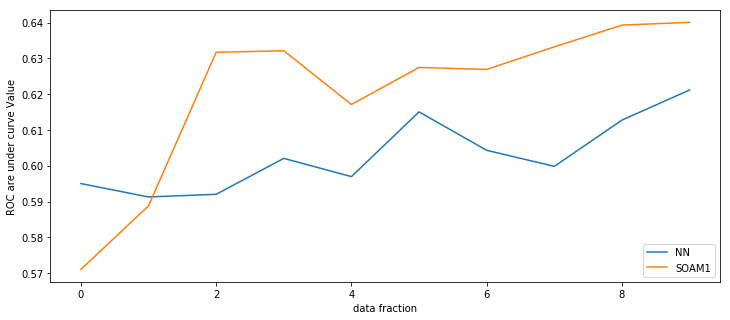

In [38]:
##output comparitive visualization
from matplotlib.pyplot import figure
plt.figure(figsize=(12, 5))
plt.plot(ROC_list_NN,label='NN')
plt.plot(ROC_list_SOAM,label='SOAM1')
plt.legend(loc='lower right')
plt.xlabel("data fraction")
plt.ylabel("ROC are under curve Value")